# Data import

In [2]:
import pandas as pd
from pathlib import Path
import os

In [3]:
# --- Configuration ---
# Set the path to the directory containing your 'perf_*' folders.
# If the script is run from the same directory that contains 'perf_lib_cpp', etc.,
# you can use '.' (current directory).
BASE_DIR = Path(
    "phuocthanh_latitude/barrier/"
)  # Or specify the full path, e.g., Path('/path/to/your/results')

# --- Find and Process CSV Files ---
all_csv_files = list(BASE_DIR.glob("perf_*/*_results.csv"))
data_frames = []

print(f"Found {len(all_csv_files)} CSV files to process:")

for csv_file in all_csv_files:
    try:
        # Extract implementation name from the parent directory name
        # e.g., 'perf_lib_cpp' -> 'lib_cpp'
        implementation_name = csv_file.parent.name.replace("perf_", "")
        print(f" - Processing '{csv_file}' (Implementation: {implementation_name})")

        # Read the CSV file
        df = pd.read_csv(csv_file)

        # Add the implementation name as a new column
        df["implementation"] = implementation_name

        # Append the DataFrame to the list
        data_frames.append(df)
    except Exception as e:
        print(f"  Error processing file {csv_file}: {e}")

# --- Combine DataFrames ---
if data_frames:
    combined_df = pd.concat(data_frames, ignore_index=True)

    print("\n--- Combined DataFrame ---")
    print("\nFirst 5 rows:")
    print(combined_df.head())

    print("\nDataFrame Info:")
    combined_df.info()

    # Display unique implementation names found
    print("\nImplementations found:")
    print(combined_df["implementation"].unique())

    # Display summary statistics for numeric columns (excluding NaN from timeouts)
    print("\nSummary Statistics (excluding timeouts):")
    # Convert relevant columns to numeric, coercing errors to NaN
    numeric_cols = ["num_threads", "total_phases", "elapsed_seconds", "phases_per_second"]
    for col in numeric_cols:
        if col in combined_df.columns:
            combined_df[col] = pd.to_numeric(combined_df[col], errors="coerce")
    print(combined_df[numeric_cols].describe())

    # You can now work with the 'combined_df' DataFrame
    # For example, save it to a new CSV:
    # combined_df.to_csv('all_barrier_results.csv', index=False)
    # print("\nCombined data saved to 'all_barrier_results.csv'")

else:
    print("\nNo CSV files were successfully processed.")

Found 5 CSV files to process:
 - Processing 'phuocthanh_latitude/barrier/perf_SR_EBO/perf_SR_EBO_results.csv' (Implementation: SR_EBO)
 - Processing 'phuocthanh_latitude/barrier/perf_lib_pthreads/perf_lib_pthreads_results.csv' (Implementation: lib_pthreads)
 - Processing 'phuocthanh_latitude/barrier/perf_SR/perf_SR_results.csv' (Implementation: SR)
 - Processing 'phuocthanh_latitude/barrier/perf_lib_openmp/perf_lib_openmp_results.csv' (Implementation: lib_openmp)
 - Processing 'phuocthanh_latitude/barrier/perf_lib_cpp/perf_lib_cpp_results.csv' (Implementation: lib_cpp)

--- Combined DataFrame ---

First 5 rows:
             timestamp    test_name  num_threads  total_phases  \
0  2025-03-08 19:10:12  perf_SR_EBO            1        100000   
1  2025-03-08 19:10:12  perf_SR_EBO            1        100000   
2  2025-03-08 19:10:12  perf_SR_EBO            1        100000   
3  2025-03-08 19:10:16  perf_SR_EBO            2        100000   
4  2025-03-08 19:10:20  perf_SR_EBO            2   

# Plotting

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker  # For formatting log scale ticks if needed
from pathlib import Path  # Only needed if you re-run the loading part

# --- Data Check (Optional but Recommended) ---
if "combined_df" not in locals() and "combined_df" not in globals():
    print("Error: 'combined_df' DataFrame not found.")
    print("Please run the previous script first to create and load the data.")
    # Or include the data loading code from above here.
    exit()

# Ensure required columns exist
required_cols = ["num_threads", "phases_per_second", "implementation"]
if not all(col in combined_df.columns for col in required_cols):
    print(f"Error: DataFrame must contain columns: {required_cols}")
    print(f"Available columns: {combined_df.columns.tolist()}")
    exit()

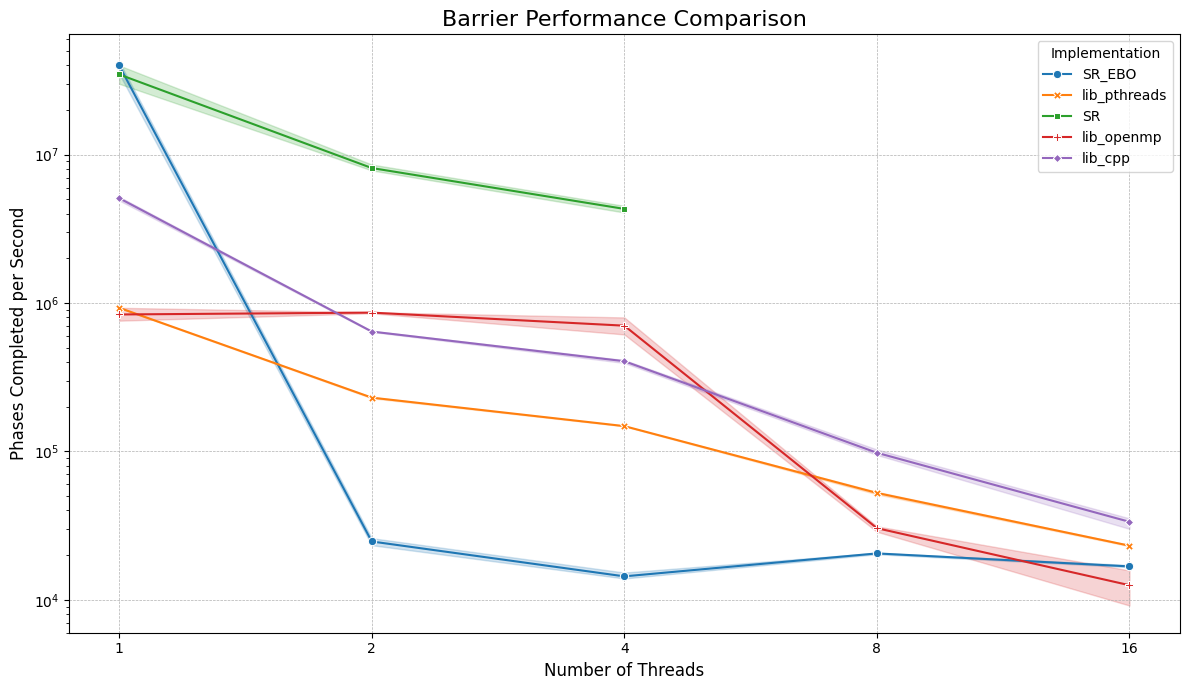

In [6]:
# --- Plotting ---
plt.figure(figsize=(12, 7))  # Adjust figure size as needed

# Create the line plot using seaborn
# - x: Independent variable (number of threads)
# - y: Dependent variable (performance metric)
# - hue: Variable to group data by (different lines/colors)
# - style: Variable to group data by (different markers/line styles - good for accessibility)
# - markers: Show markers at each data point
# - errorbar: Show variability (default is 95% CI using bootstrap)
#            Alternatives: ('sd', 1) for +/- 1 standard deviation, None to disable
lineplot = sns.lineplot(
    data=combined_df,
    x="num_threads",
    y="phases_per_second",
    hue="implementation",
    style="implementation",  # Use different markers/line styles per implementation
    markers=True,  # Show markers on the points
    dashes=False,  # Use solid lines
    errorbar=("ci", 95),  # Show 95% confidence interval (default, handles NaN)
    # errorbar = ('sd', 1) # Uncomment to show standard deviation instead
)

# --- Customization ---
plt.title("Barrier Performance Comparison", fontsize=16)
plt.xlabel("Number of Threads", fontsize=12)
plt.ylabel("Phases Completed per Second", fontsize=12)

# Optional: Use a logarithmic scale for the x-axis if thread counts are powers of 2
# This often spaces the points more evenly for typical multithreading tests (1, 2, 4, 8, 16...)
plt.xscale("log", base=2)
# Ensure x-axis ticks are clearly showing the actual thread counts tested
unique_threads = sorted(combined_df["num_threads"].dropna().unique())
plt.xticks(unique_threads)
lineplot.xaxis.set_major_formatter(ticker.ScalarFormatter())  # Use normal numbers for labels

# Optional: Use a logarithmic scale for y-axis if performance spans several orders of magnitude
plt.yscale('log')

plt.grid(True, which="major", linestyle="--", linewidth=0.5)  # Add grid lines
plt.legend(title="Implementation")  # Add a legend with a title
plt.tight_layout()  # Adjust layout to prevent labels overlapping

# --- Display and/or Save Plot ---
# To save the plot to a file:
# plt.savefig('barrier_performance_comparison.png', dpi=300) # Save with high resolution
# print("Plot saved as 'barrier_performance_comparison.png'")

# To display the plot:
plt.show()